In [9]:
import tensorflow as tf
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
import mitdeeplearning as mdl
!apt-get install abcmidi timidity > /dev/null 2>&1

tf.config.set_visible_devices([], "GPU")

In D:\AnacondaNavigator\lib\site-packages\matplotlib\mpl-data\stylelib\classic (2).mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\AnacondaNavigator\lib\site-packages\matplotlib\mpl-data\stylelib\classic (2).mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\AnacondaNavigator\lib\site-packages\matplotlib\mpl-data\stylelib\classic (2).mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In D:\AnacondaNavigator\lib\site-packages\matplotlib\mpl-data\stylelib\classic (2).mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\AnacondaNavigator\lib\site-packages\matplotlib\mpl-data\stylelib\classic (2).mplstyle: 
The savefig.jpeg_quali

In [10]:
songs = mdl.lab1.load_training_data()

Found 817 songs in text


In [11]:
e1 = songs[0]
print(e1)

X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [19]:
songs_join = "\n\n".join(songs)
vocab = sorted(set(songs_join))


In [21]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

In [32]:

print(char2idx.get("c"))

58


In [43]:

### Vectorize the songs string ###

'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping
    above to convert from vocab characters to the corresponding indices.

  NOTE: the output of the `vectorize_string` function 
  should be a np.array with `N` elements, where `N` is
  the number of characters in the input string
'''

def vectorize_string(string):
    arr = []
    for i in string:
        arr.append(char2idx.get(i))
    
    return np.array(arr)

vectorized_songs = vectorize_string(songs_join)

In [44]:
vectorized_songs

array([49, 22, 13, ..., 22, 82,  2])

In [46]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_join[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


In [58]:
def get_batch(vectorized_songs, seq_length, batch_size):
    n = vectorized_songs.shape[0] - 1
    idx = np.random.choice(n-seq_length, batch_size)
    
    '''TODO: construct a list of input sequences for the training batch'''
    input_batch = [vectorized_songs[i : i + seq_length] for i in idx]
    '''TODO: construct a list of output sequences for the training batch'''
    output_batch = [vectorized_songs[i + 1 : i + seq_length +1 ] for i in idx]
    
    x_batch = np.reshape(input_batch, [batch_size, seq_length])
    y_batch = np.reshape(output_batch, [batch_size, seq_length])
    
    return x_batch, y_batch
    
    

In [59]:
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args): 
   print("======\n[FAIL] could not pass tests")
else: 
   print("======\n[PASS] passed all tests!")
     

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [60]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 1 (' ')
  expected output: 61 ('f')
Step   1
  input: 61 ('f')
  expected output: 59 ('d')
Step   2
  input: 59 ('d')
  expected output: 61 ('f')
Step   3
  input: 61 ('f')
  expected output: 56 ('a')
Step   4
  input: 56 ('a')
  expected output: 82 ('|')


In [92]:
def LSTM(rnn_units):
    return tf.keras.layers.LSTM(
        rnn_units, 
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        recurrent_activation='sigmoid',
        stateful=True
    )

In [94]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        LSTM(rnn_units),
        tf.keras.layers.Dense(vocab_size)
    ])
    
    return model
    

In [95]:
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)


In [96]:
print(y)

[[60 61 82 ... 59 15 22]
 [32 31 32 ...  1 58 27]
 [30 14 82 ... 61 62 82]
 ...
 [60  1 60 ... 26  1 26]
 [ 2  0 26 ... 82 29 31]
 [15 19 16 ... 60 59 58]]


In [97]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


In [98]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
sampled_indices

array([23,  4, 28, 33, 44, 28,  6, 79, 37, 20, 77, 82, 11, 59, 59, 18, 44,
       79, 51, 22, 49, 69, 58, 51, 12,  9, 75, 79, 82, 49, 70, 66, 75, 63,
       57, 72, 44, 70, 56, 73, 54, 34, 36, 48, 36, 47, 74, 20, 66,  8, 53,
       66, 38, 20, 40, 16, 22, 65, 68, 17, 31, 18, 81, 53, 47, 54, 16, 67,
       55, 16, 40, 33, 57, 38, 15, 48, 72, 78, 66, 43,  5, 18, 74, 36,  0,
       18, 38, 56, 75, 13, 59, 68, 69, 70, 36, 64, 19, 41, 20, 35],
      dtype=int64)

In [99]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 ' dBB2|AFF2 ABde|fedc d3:|!\ne|faa2 bafb|afef dBB2|faa2 fbb2|abba b3a|!\nfaa2 bafb|afef dBB2|AFF2 ABde|'

Next Char Predictions: 
 "<#CHSC(xL8v|/dd6SxZ:XncZ0-tx|XokthbqSoar^IKWKVs8k,]kM8O4:jm5F6z]V^4l_4OHbM3WqwkR'6sK\n6Mat1dmnoKi7P8J"


In [100]:
def compute_loss(labels, logits):
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return loss

example_batch_loss = compute_loss(y, pred)


In [101]:
print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())
     

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.418812


In [102]:
n_training_iterations = 2000
batch_size = 4
seq_length = 100
learning_rate = 5e-3

vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

checkpoints= "./training_checkpoints"
check_pre = os.path.join(checkpoints, "my_ckpt")

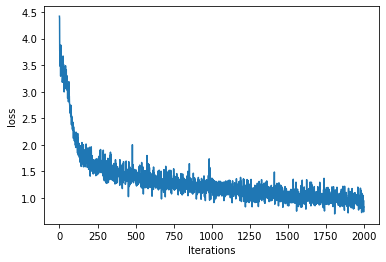

100%|███████████████████████████████████████████████████| 2000/2000 [38:41<00:00,  1.16s/it]


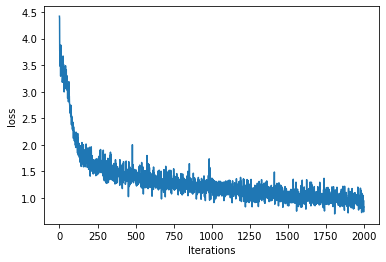

In [117]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(x,y):
    with tf.GradientTape() as tape:
        y_hat = model(x)
        loss = compute_loss(y, y_hat)
        
    grads = tape.gradient(loss,model.trainable_variables)
    
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
    return loss
    
    
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel="Iterations", ylabel="loss")
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for iter in tqdm(range(n_training_iterations)):

    # Grab a batch and propagate it through the network
    x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
    loss = train_step(x_batch, y_batch)

    # Update the progress bar
    history.append(loss.numpy().mean())
    plotter.plot(history)

    # Update the model with the changed weights!
    if iter % 100 == 0:     
        model.save_weights(check_pre)
    
# Save the trained model and the weights
model.save_weights(check_pre)

In [118]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoints))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (1, None, 256)            21248     
                                                                 
 lstm_14 (LSTM)              (1, None, 1024)           5246976   
                                                                 
 dense_14 (Dense)            (1, None, 83)             85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [128]:
def gen(model, starting_string, generation_len=1000):
    inp = vectorize_string(starting_string)
    input_eval = inp
    input_eval = tf.expand_dims(input_eval, 0)
    
    text_gen = []
    
    model.reset_states()
    tqdm._instances.clear()
    
    for i in tqdm(range(generation_len)):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions,0)
        
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        
        input_eval = tf.expand_dims([predicted_id], 0)
        
        text_gen.append(idx2char[predicted_id])
        
    return (starting_string + "".join(text_gen))

In [135]:
generated_text = gen(model, starting_string="D", generation_len=1000) # TODO


100%|██████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.77it/s]


In [136]:
generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)
     

Found 5 songs in text


In [137]:
print(generated_text)

DE FED2|!
BEPE BEEC|BEE2 BcdA|B2G2 F2D2|d3f e2d:|!

X:213
T:McD Major
A|dBAd B3d|e2d2 edBA|GEAB dBdB|A2AB AFEF|!
G2GA GABd|edBd edBd|BGDB GA|BGGA BGG2|!
eaa2 bage|dBcB dBGB|eged edBA|GABG AEE2:|!

X:84
M:Challiy's No. 1
Z: id:dc-reel-196
M:C
L:1/8
K:E Dorian
A|BABF ABde|fdec dedB|AFED FAA2|dEAB GEED|EAAG ABc|d3:|!
egg2 faa2|agag fded|cABG ABGE|DED2 GBAc|Bcde fdf:|!
egg2 agfd|eBB2 BABB|dBAc BGEE|GBB2 dBgB|!
eAB2 eBf2|gBB2 GBdB|cAA2:|!

X:297
T:Jathyy's
Z: id:dc-reel-92
M:C
L:1/8
K:A Major
ag|fgfe dcBA|(3efc's
Z: id:dc-reel-21
M:C
L:1/8
K:D Major
A|defe f3a|a3g fedg|ecc2 dBcA|defg a2ga|!
bgeg f2de|fgaf gfed|eaag afdf|a^geb a=gab|!
f2af beef|gfga gfde|fgaf g3e|fgaf g2:|!

X:163
T:O'munin's Favlisiny
Z: id:dc-ocarolan-11
M: id:dc-reel-330
M:C
L:1/8
K:A Major
dB|Acdf ecde|fece feec|dfe^c dfed|cded ^cded|!
dgg2 dggd|egfg ecce|d2ef g2fg|!
afgf gfeg|fedf agfd|egg2 agg2|afa^f feec|[1 dB(Bdef g4|]!

X:124
T:Falley's
Z: id:dc-jig-136
M:6/8
L:1/8
K:A Major
A|dAF DFA|d2e fdB|AGF G2A|BdB AFE|F2D FED